# Linear Regression Model - CDA2/2Da

In [1]:
import pandas as pd
import numpy as np

In [2]:
def import_swiss_votes_data(filepath):
    """
    Import Swiss votes data from a CSV file.
    
    Parameters:
    filepath (str): Path to the CSV file
    
    Returns:
    pandas.DataFrame: dataframe with a subselect of csv data
    """
    
    # Import the CSV data
    # The data doesn't have headers and uses semicolons as separators
    df = pd.read_csv(filepath, sep=';')
    
    # Based on the data structure, we can create appropriate column names
    # This is a simplified set of column names based on the visible patterns
    columns_to_use = [
        'anr', 'datum', 'titel_kurz_d', 'titel_off_d', 'stichwort', 'swissvoteslink', 'rechtsform', 'd1e1', 'd1e2', 'd1e3', 
        'dep', 'br-pos', 'bv-pos', 'nr-pos', 'sr-pos', 'annahme', 'berecht', 'stimmen', 'bet', 'leer', 'ungultig', 'gultig', 'volkja',
        'volknein', 'volkja-proz', 'bfsdash-de', 'bfsmap-de', 'nach_cockpit_d',

        # y variable für die logistische Regression
        'p-fdp',

        # Kantonale Parameter
        #'zh-ja', 'be-ja', 'zg-ja', 'so-ja', 'ag-ja', 'ti-ja', 'vs-ja', 'bs-ja', 'bl-ja',
        #'ju-ja', 'ne-ja', 'ow-ja', 'nw-ja', 'ai-ja', 'sg-ja', 'tg-ja', 'ar-ja', 'gl-ja',
        #'gr-ja', 'sh-ja', 'vd-ja', 'ge-ja', 'fr-ja', 'ur-ja', 'lu-ja', 'sz-ja',

        'zh-stimmen', 'be-stimmen', 'zg-stimmen', 'so-stimmen', 'ag-stimmen', 'ti-stimmen', 'vs-stimmen', 'bs-stimmen', 'bl-stimmen',
        'ju-stimmen', 'ne-stimmen', 'ow-stimmen', 'nw-stimmen', 'ai-stimmen', 'sg-stimmen', 'tg-stimmen', 'ar-stimmen', 'gl-stimmen',
        'gr-stimmen', 'sh-stimmen', 'vd-stimmen', 'ge-stimmen', 'fr-stimmen', 'ur-stimmen', 'lu-stimmen', 'sz-stimmen',

        # used for weigthed continuous values        
        'zh-gultig', 'be-gultig', 'zg-gultig', 'so-gultig', 'ag-gultig', 'ti-gultig', 'vs-gultig', 'bs-gultig', 'bl-gultig',
        'ju-gultig', 'ne-gultig', 'ow-gultig', 'nw-gultig', 'ai-gultig', 'sg-gultig', 'tg-gultig', 'ar-gultig', 'gl-gultig',
        'gr-gultig', 'sh-gultig', 'vd-gultig', 'ge-gultig', 'fr-gultig', 'ur-gultig', 'lu-gultig', 'sz-gultig',

        'zh-japroz', 'be-japroz', 'zg-japroz', 'so-japroz', 'ag-japroz', 'ti-japroz', 'vs-japroz', 'bs-japroz', 'bl-japroz',
        'ju-japroz', 'ne-japroz', 'ow-japroz', 'nw-japroz', 'ai-japroz', 'sg-japroz', 'tg-japroz', 'ar-japroz', 'gl-japroz',
        'gr-japroz', 'sh-japroz', 'vd-japroz', 'ge-japroz', 'fr-japroz', 'ur-japroz', 'lu-japroz', 'sz-japroz',
    ]
    # srja, srnein, nrja, nrnein
    # Parteiparolen könnten spannend sein, p-fdp, p-sps, p-svp, p-mitte, etc.

    df_subset = df[columns_to_use]
    
    print(f"Cleaned data: {df.shape[0]} rows, {df.shape[1]} columns")
    return df_subset

swissvotes_data_path = '../data/raw/swissvotes_data.csv'

swissvotes_data_subset = import_swiss_votes_data(swissvotes_data_path)

Cleaned data: 696 rows, 874 columns


In [3]:
def clean_and_prepare_data(df_to_clean):
    
    # 1. Convert date to datetime format
    # Transform dates from DD.MM.YYYY to YYYY-MM-DD format
    df_to_clean['datum'] = pd.to_datetime(df_to_clean['datum'], format='%d.%m.%Y', errors='coerce')
    
    # 2. Replace placeholder values with NaN
    # In the data, '.' is used as unknown and '9999' appears to be not applicable (organisation doesn't exist)
    # We will be replaceing all these values with nan
    placeholder_values = ['.', '9999', '']
    for placeholder in placeholder_values:
        df_to_clean.replace(placeholder, np.nan, inplace=True)
    
    # 3. Convert boolean-like columns (0/1) to boolean
    boolean_cols = [col for col in df_to_clean.columns if 
                    df_to_clean[col].dropna().astype(str).str.match(r'^[01]$').all()]
    
    for col in boolean_cols:
        df_to_clean[col] = df_to_clean[col].map({0: False, '0': False, 1: True, '1': True})
    
    # 4. Strip whitespace from string columns
    string_cols = df_to_clean.select_dtypes(include=['object']).columns
    for col in string_cols:
        df_to_clean[col] = df_to_clean[col].astype(str).str.strip()
        # Convert back to object type if the column had empty strings that were converted to 'nan'
        df_to_clean[col] = df_to_clean[col].replace('nan', np.nan)
    
    # 6. Handle URLs - validate and clean
    url_cols = [col for col in df_to_clean.columns if 'url' in col.lower()]
    for col in url_cols:
        if col in df_to_clean.columns:
            # Basic URL validation - ensure URLs start with http
            mask = df_to_clean[col].notna() & ~df_to_clean[col].astype(str).str.startswith(('http://', 'https://'))
            if mask.any():
                print(f"Warning: Found {mask.sum()} invalid URLs in column {col}")
                
    # 7. Remove completely empty rows
    df_to_clean = df_to_clean.dropna(how='all')
    
    # 8. Handle trailing semicolons that might have created extra empty columns
    # Drop columns that are completely empty
    df_to_clean = df_to_clean.dropna(axis=1, how='all')
    
    return df_to_clean

In [4]:
swissvotes_data_subset_cleaned = clean_and_prepare_data(swissvotes_data_subset)

swissvotes_data_subset_cleaned.head()

,anr,datum,titel_kurz_d,titel_off_d,stichwort,swissvoteslink,rechtsform,d1e1,d1e2,d1e3,...,ar-japroz,gl-japroz,gr-japroz,sh-japroz,vd-japroz,ge-japroz,fr-japroz,ur-japroz,lu-japroz,sz-japroz
0,1.0,1848-09-12,Bundesverfassung der schweizerischen Eidgenoss...,Totalrevision vom 12. September 1848,NaN,https://swissvotes.ch/vote/1.00,1,1,1.2,1.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,1866-01-14,Mass und Gewicht,Festsetzung von Mass und Gewicht,NaN,https://swissvotes.ch/vote/2.00,1,1,1.5,1.52,...,24.85,30.85,5.62,40.33,66.56,87.64,58.26,13.53,19.64,24.60
2,3.0,1866-01-14,Gleichstellung der Juden und Naturalisierten m...,Gleichstellung der Juden und Naturalisierten m...,NaN,https://swissvotes.ch/vote/3.00,1,12,12.3,NaN,...,44.23,67.74,10.35,53.30,62.70,85.95,56.79,6.05,19.40,22.27
3,4.0,1866-01-14,Stimmrecht der Niedergelassenen in Gemeindeang...,Stimmrecht der Niedergelassenen in Gemeindeang...,NaN,https://swissvotes.ch/vote/4.00,1,1,1.4,1.43,...,46.01,55.78,9.89,46.42,10.65,37.97,20.44,5.88,19.28,20.47
4,5.0,1866-01-14,Besteuerung und zivilrechtliche Verhältnisse d...,Besteuerung und zivilrechtliche Verhältnisse d...,NaN,https://swissvotes.ch/vote/5.00,1,6,6.1,6.12,...,3.48,64.30,10.45,46.67,6.79,58.28,19.40,5.98,15.95,15.64


## Importieren und Vorbereitung der Daten der Religionszugehörigkeit

In [5]:
# === 1. CSV-Datei laden (korrekter Pfad & Komma als Trennzeichen) ===
file_path = '../data/raw/rel_gemeinde.csv'
df = pd.read_csv(file_path, sep=",", encoding="utf-8")

#--Wrangling
# === 2. Leere/unnötige Spalten entfernen ===
df = df.loc[:, ~df.columns.str.match(r"^Unnamed")]

# === 3. In Long-Format bringen ===
id_vars = ['Regions_ID', 'Regionsname', 'Kanton']
value_vars = [col for col in df.columns if col.startswith("y_")]

df_long = pd.melt(df,
                  id_vars=id_vars,
                  value_vars=value_vars,
                  var_name="Jahr",
                  value_name="Religion")

# === 4. Jahr bereinigen (z. B. y_1850 → 1850 als int) ===
df_long["Jahr"] = df_long["Jahr"].str.extract(r"y_(\d+)").astype(int)

# === 5. Encoding-Fehler beheben (‚â• → ≥) ===
df_long["Religion"] = df_long["Religion"].str.replace("‚â•", "≥", regex=False)

# === 6. all values to lower case
df_long["Religion"] = df_long["Religion"].str.lower()

# === 7. Nur gültige Kantone (z. B. ZH, BE, AG etc.) ===
df_long["Kanton"] = df_long["Kanton"].astype(str).str.strip()
df_long = df_long[df_long["Kanton"].str.match(r"^[A-Z]{2}$")]

# === 8. Aggregation: häufigste Religion pro Kanton & Jahr ===
df_kanton_agg = (
    df_long
    .groupby(["Kanton", "Jahr"])["Religion"]
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index()
)

In [6]:
print(df_kanton_agg['Jahr'].unique())

# Verify that we have the correct amount of values for the religion:
assert (len(df_kanton_agg['Jahr'].unique()) == 17)

print("")

print(df_kanton_agg['Religion'].unique())

# Verify that we have the correct amount of values for the religion:
assert (len(df_kanton_agg['Religion'].unique()) == 8)

[1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980
 1990 2000 2014]

['mehrheit katholisch: ≥ 80,0 %' 'mehrheit reformiert: ≥ 80,0 %'
 'mehrheit reformiert: 60,0 - 79,9 %' 'mehrheit katholisch: 60,0 - 79,9 %'
 'mehrheit katholisch: 40,0 - 59,9 %' 'mehrheit reformiert: 40,0 - 59,9 %'
 'mehrheit mit anderer oder ohne religionszugehörigkeit: 40,0 - 59,9 %'
 None]


## Prepare and Combine Data frames

### Data Frames
Wir testen zwei verschiedene Modelle:
– Dummy-Werte als Werte für die lineare Regression.
– eine Skalarwerteskala von -1 bis 1. 1 steht für eine hohe protestantische und -1 für eine hohe katholische Zugehörigkeit.

### Daten

Wir werden alle Abstimmungen verwenden, die als Wirtschaftsabstimmungen klassifiziert wurden auf Swissvotes

Siehe [Swissvotes](https://swissvotes.ch/votes?term=&full_text=1&policy_area=4&legal_form=1&legal_form=2&legal_form=3&legal_form=4&legal_form=5&result=0&result=1&from_date=&to_date=&position_federal_council=1&position_federal_council=2&position_federal_council=3&position_federal_council=-1&position_national_council=1&position_national_council=2&position_national_council=3&position_council_of_states=1&position_council_of_states=2&position_council_of_states=3&sort_by=&sort_order=)

In [7]:
# Prepare the data with all the necessary 

# List of anr (Abstimmungsnummer) for all votes that are in the used for the training, crossvalidation and testing of the model.
economic_votes_ids = [677, 663, 662, 661, 655, 654, 653, 652, 650, 648,
                      643, 637, 636, 634, 627, 619, 618, 611, 601, 598,
                      589, 585, 583, 575, 574, 568, 565, 559, 558, 557,
                      555, 531, 530, 523, 521, 519, 503, 489.2, 489.2, 489.1, 486, 
                      448, 436, 433, 424, 396, 390, 388, 386, 352, 335, 
                      329, 319, 311.2, 311.1, 310, 307, 305, 294, 282, 264, 
                      263, 262, 255.2, 255.1, 247, 246, 240, 239, 238, 237, 
                      233, 230, 229, 220, 210, 209, 208, 198, 188, 186, 
                      184, 177, 175, 174.1, 174.2, 170, 165, 163, 158, 156.2, 
                      156.1, 155, 146, 143, 142, 141, 140, 137, 131, 126.2, 
                      126.1, 121, 120, 106, 98, 84, 82.2, 82.1, 81, 67, 
                      65, 64, 60, 52, 50, 45, 42, 41, 38, 37, 
                      33, 32, 27, 23, 22, 17, 15, 10, 9]

# Subselect of economic votes based on the ids
df_full_model_data = swissvotes_data_subset_cleaned[swissvotes_data_subset_cleaned["anr"].isin(economic_votes_ids)]

df_full_model_data.head()

,anr,datum,titel_kurz_d,titel_off_d,stichwort,swissvoteslink,rechtsform,d1e1,d1e2,d1e3,...,ar-japroz,gl-japroz,gr-japroz,sh-japroz,vd-japroz,ge-japroz,fr-japroz,ur-japroz,lu-japroz,sz-japroz
8,9.0,1866-01-14,Schutz des geistigen Eigentums,Schutz des geistigen Eigentums,NaN,https://swissvotes.ch/vote/9.00,1,4,4.1,4.12,...,40.38,65.48,8.12,47.00,10.89,69.05,46.50,16.21,19.20,27.27
9,10.0,1866-01-14,Verbot der Lotterie und Hasardspiele,Verbot der Lotterie und Hasardspiele,NaN,https://swissvotes.ch/vote/10.00,1,4,4.1,4.13,...,41.51,78.66,11.04,48.20,14.19,75.71,21.27,10.76,21.76,23.06
14,15.0,1876-04-23,Banknotengesetz,Bundesgesez über die Ausgabe und Einlösung von...,NaN,https://swissvotes.ch/vote/15.00,2,4,4.3,4.31,...,53.66,59.58,9.39,38.02,51.38,8.55,63.87,11.16,11.03,61.87
16,17.0,1877-10-21,Fabrikgesetz,Bundesgesez betreffend die Arbeit in den Fabriken,NaN,https://swissvotes.ch/vote/17.00,2,4,4.2,4.21,...,28.04,66.78,78.52,72.97,29.05,43.28,18.50,70.34,59.81,75.10
21,22.0,1880-10-31,Banknotenmonopol,Bundesbeschluss betreffend den durch das Volks...,NaN,https://swissvotes.ch/vote/22.00,1,4,4.3,4.31,...,30.28,68.77,65.32,66.48,1.66,5.30,3.17,36.54,19.26,17.45


In [8]:
# Keep only rows where p-fdp is either 1 or 2
df_full_model_data = df_full_model_data[df_full_model_data['p-fdp'].isin(["1", "2"])]

# Update target_col based on p-fdp
df_full_model_data['Wirtschaftsfördernd'] = df_full_model_data['p-fdp'].map({"1": 1, "2": 0})

df_full_model_data.head()

,anr,datum,titel_kurz_d,titel_off_d,stichwort,swissvoteslink,rechtsform,d1e1,d1e2,d1e3,...,gl-japroz,gr-japroz,sh-japroz,vd-japroz,ge-japroz,fr-japroz,ur-japroz,lu-japroz,sz-japroz,Wirtschaftsfördernd
40,41.0,1894-03-04,Bundeskompetenz für das Gewerbewesen,Bundesbeschluss vom 20. Dezember 1893 betreffe...,NaN,https://swissvotes.ch/vote/41.00,1,4,4.1,NaN,...,67.62,27.65,57.14,21.22,23.52,56.63,21.57,42.94,37.68,1
41,42.0,1894-06-03,Initiative «zur Gewährleistung des Rechts auf ...,Volksinitiative «zur Gewährleistung des Rechts...,NaN,https://swissvotes.ch/vote/42.00,3,4,4.2,4.24,...,35.33,18.97,19.26,8.47,37.34,11.51,17.35,10.58,12.01,0
44,45.0,1895-09-29,Zündhölzchenmonopol,Bundesbeschluss über die Ergänzung der Bundesv...,NaN,https://swissvotes.ch/vote/45.00,1,4,4.1,4.12,...,72.22,22.21,77.88,7.07,16.98,6.74,15.99,43.51,37.30,1
49,50.0,1897-02-28,Gesetz über die Errichtung der schweizerischen...,Bundesgesetz über die Errichtung der schweizer...,NaN,https://swissvotes.ch/vote/50.00,2,1,1.3,1.34,...,64.79,34.54,72.50,9.92,22.76,16.84,10.94,36.68,15.69,1
51,52.0,1897-07-11,Bundeskompetenz für die Lebensmittelpolizei,Bundesbeschluss betreffend Bundesgesetzgebung ...,NaN,https://swissvotes.ch/vote/52.00,1,4,4.1,4.15,...,36.49,51.76,87.26,73.73,50.01,23.17,69.99,55.35,69.16,1


### Qualität der Daten und kurzer Exkurs

#### Verteilung der Abstimmungen seit Beginn des Datensatzes

Text(0.02, 0.02, 'Totale Abstimmungen: 113\nDurchschnitt: 1.9 Abstimmungen/Jahr\nMedian: 2.0 Abstimmungen/Jahr\nMeiste Abstimmungen: 5 in 1976\nWenigste Abstimmungen: 1 in 1895')

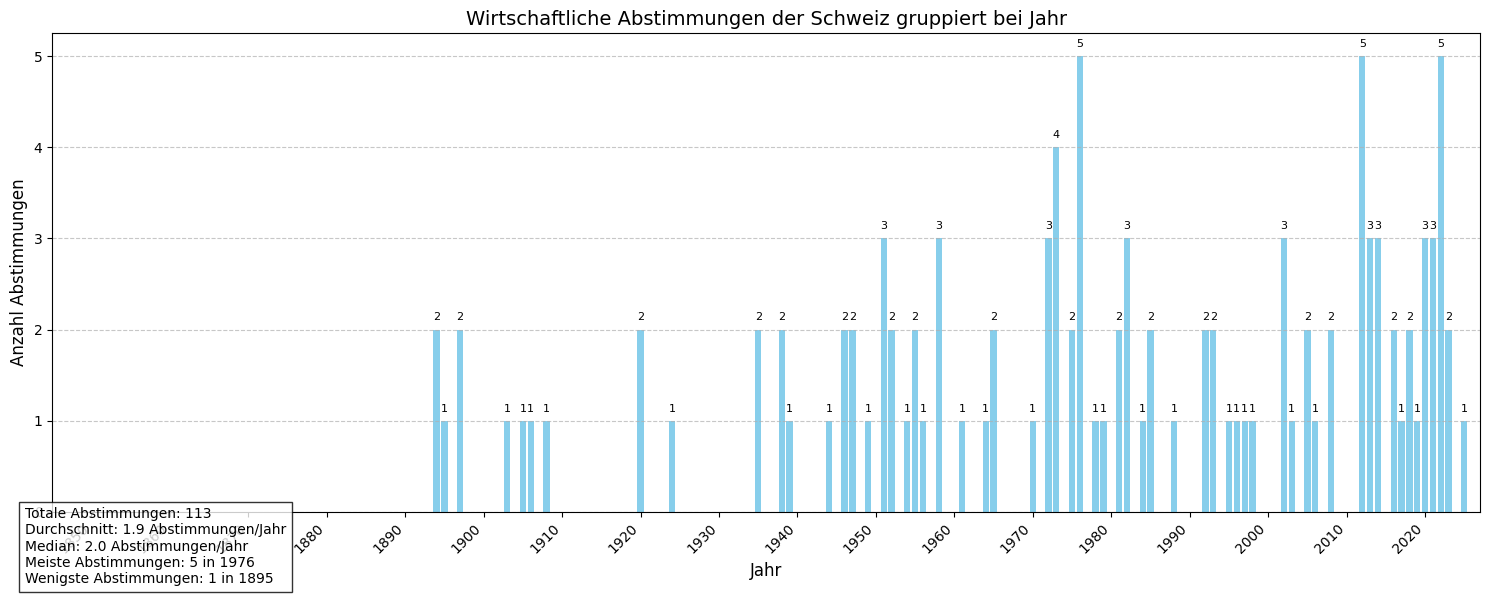

In [9]:
import matplotlib.pyplot as plt

# Creating a histogram showing the number of votes per year.
df_histogram_votes = df_full_model_data.copy()

# Extract the year from the date column
df_histogram_votes['year'] = df_histogram_votes['datum'].dt.year

# Count votes per year
vote_counts = df_histogram_votes['year'].value_counts().sort_index()

# Create the histogram as a bar plot
plt.figure(figsize=(15, 6))
ax = plt.bar(vote_counts.index, vote_counts.values, color='skyblue', width=0.8)

# Add labels and title
plt.xlabel('Jahr', fontsize=12)
plt.ylabel('Anzahl Abstimmungen', fontsize=12)
plt.title("Wirtschaftliche Abstimmungen der Schweiz gruppiert bei Jahr", fontsize=14)

# Add count labels above bars where count > 0
for year, count in vote_counts.items():
    if count > 0:
        plt.text(year, count + 0.1, str(count), ha='center', fontsize=8)

# Set x-axis to show only every 10th year
decade_years = list(range(1850, 2030, 10))
plt.xticks(decade_years, rotation=45, ha='right')

# Set the x-axis limits explicitly
plt.xlim(1845, 2027)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Annotate with statistics
total_votes = vote_counts.sum()
avg_votes = vote_counts.mean()
median_votes = vote_counts.median()
max_year = vote_counts.idxmax()
min_year = vote_counts.idxmin()

stats_text = f"Totale Abstimmungen: {total_votes}\nDurchschnitt: {avg_votes:.1f} Abstimmungen/Jahr\nMedian: {median_votes:.1f} Abstimmungen/Jahr\n"
stats_text += f"Meiste Abstimmungen: {vote_counts.max()} in {max_year}\nWenigste Abstimmungen: {vote_counts.min()} in {min_year}"

plt.figtext(0.02, 0.02, stats_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

#### Boxplots für die Darstellung der Ja-Stimmen über alle wirtschaftlichen Abstimmungen

Text(0.02, 0.02, 'Overall Statistics:\nMedian: 50.2%\nMean: 50.4%\nQ1-Q3: 34.8% - 65.1%\nRange: 11.5% - 87.7%')

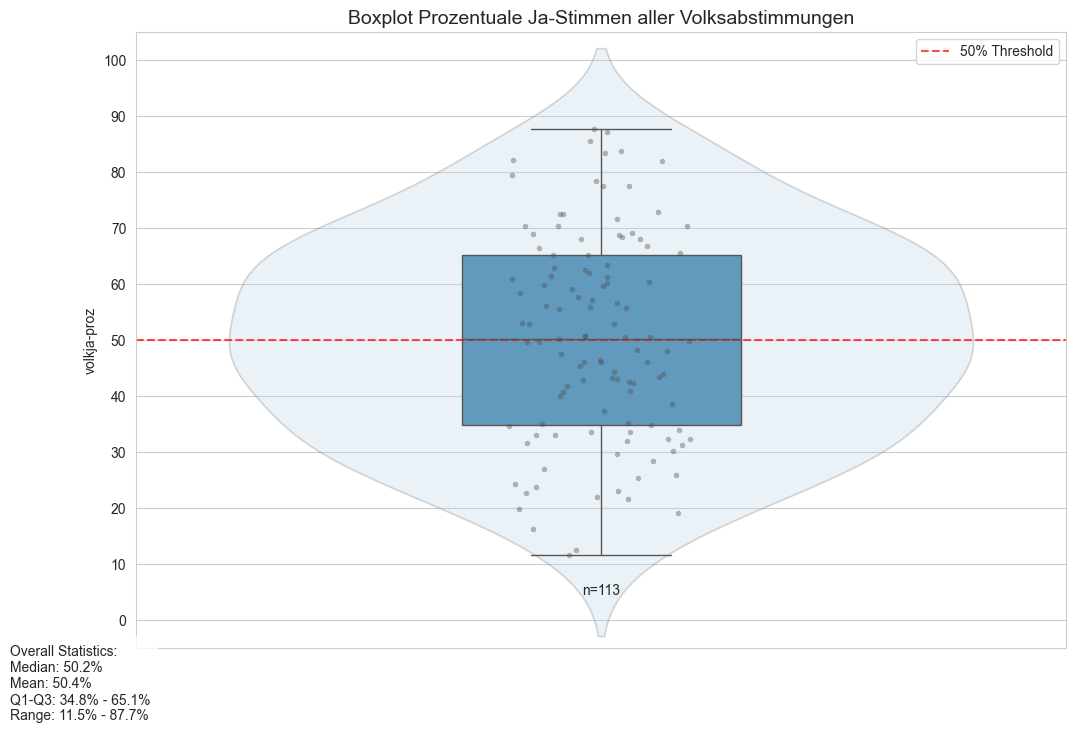

In [10]:
import seaborn as sns

# Creating a boxplot for the yes percetage of the whole country
df_boxplot_yes_percentage = df_full_model_data.copy()

# Set Seaborn style for better aesthetics
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(12, 8))

color_palette = 'Blues'

# Create a single boxplot for all data
ax = sns.boxplot(y='volkja-proz', data=df_boxplot_yes_percentage, color=sns.color_palette(color_palette)[3], width=0.3)

# Add a violin plot for better distribution visualization
sns.violinplot(y='volkja-proz', data=df_boxplot_yes_percentage, color=sns.color_palette(color_palette)[1], 
               alpha=0.3, inner=None)

# Add individual data points
sns.stripplot(y='volkja-proz', data=df_boxplot_yes_percentage, color='0.3', size=4, alpha=0.4, jitter=True)

# Add count of total data points
plt.text(0, df_boxplot_yes_percentage['volkja-proz'].min() - 5, f'n={len(df_boxplot_yes_percentage)}', ha='center', va='top', fontsize=10)

# Set y-axis to percentage range (0-100) with appropriate ticks
plt.ylim(-5, 105)
plt.yticks(np.arange(0, 101, 10))

# Calculate overall statistics
overall_median = df_boxplot_yes_percentage['volkja-proz'].median()
overall_mean = df_boxplot_yes_percentage['volkja-proz'].mean()
overall_q1 = df_boxplot_yes_percentage['volkja-proz'].quantile(0.25)
overall_q3 = df_boxplot_yes_percentage['volkja-proz'].quantile(0.75)

# Add overall statistics text
stats_text = f"Overall Statistics:\n"
stats_text += f"Median: {overall_median:.1f}%\n"
stats_text += f"Mean: {overall_mean:.1f}%\n"
stats_text += f"Q1-Q3: {overall_q1:.1f}% - {overall_q3:.1f}%\n"
stats_text += f"Range: {df_boxplot_yes_percentage['volkja-proz'].min():.1f}% - {df_boxplot_yes_percentage['volkja-proz'].max():.1f}%"
    
# For single boxplot, add threshold line
plt.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% Threshold')
plt.legend(loc='upper right')
plt.title("Boxplot Prozentuale Ja-Stimmen aller Volksabstimmungen", fontsize=14)

# Add the statistics text box
plt.figtext(0.02, 0.02, stats_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

#### Kantone nach Anzahl Stimme

In [11]:
#Prepare additional data frame for visualizations
df_agg_votes_stats_per_canton = df_full_model_data.copy()

# Define canton codes
canton_codes = ['zh', 'be', 'zg', 'so', 'ag', 'ti', 'vs', 'bs', 'bl',
               'ju', 'ne', 'ow', 'nw', 'ai', 'sg', 'tg', 'ar', 'gl',
               'gr', 'sh', 'vd', 'ge', 'fr', 'ur', 'lu', 'sz']

df_agg_votes_stats_mean_per_cantons = []

# Generate vote data for 132 votes
for id, vote in df_agg_votes_stats_per_canton.iterrows():
    year = vote['datum'].year
    
    national_result = vote['volkja-proz']

    # National decision (accepted if > 50%)
    national_accepted = national_result > 50

    vote_count_valid_overall = float(vote['gultig'])
    
    # For each canton, generate a row
    for canton in canton_codes:
        # Skip entries for cantons (Jura before 1979)
        if canton == 'ju' and year < 1979:
            continue

        canton_result_col = f"{canton}-japroz"

        aligned = None

        voting_percentage = 0
        
        # Skip if canton data is missing
        if not (canton_result_col not in vote or pd.isna(vote[canton_result_col])):
            # Canton result
            canton_result = vote[canton_result_col]
            
            # Canton decision
            canton_accepted = float(canton_result) > 50
            
            # Check if canton aligned with national outcome
            aligned = canton_accepted == national_accepted
            
            
        # Add row to dataset
        df_agg_votes_stats_mean_per_cantons.append({
            'vote_id': vote['anr'],
            'year': year,
            'canton': canton,
            'ja_prozent': float(vote[f'{canton}-japroz']),
            'volk_ja_prozent': float(vote['volkja-proz']),
            'stimmen': float(vote[f'{canton}-stimmen']),
            'volk_canton_aligned': aligned
        })

df_agg_votes_stats_per_canton = pd.DataFrame(df_agg_votes_stats_mean_per_cantons)

grouped_data = df_agg_votes_stats_per_canton.groupby(['canton'])['stimmen'].agg('mean')

C:\Users\aaron\AppData\Local\Temp\ipykernel_22856\3479925184.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=grouped_data.index, y=grouped_data.values, palette=color_palette)


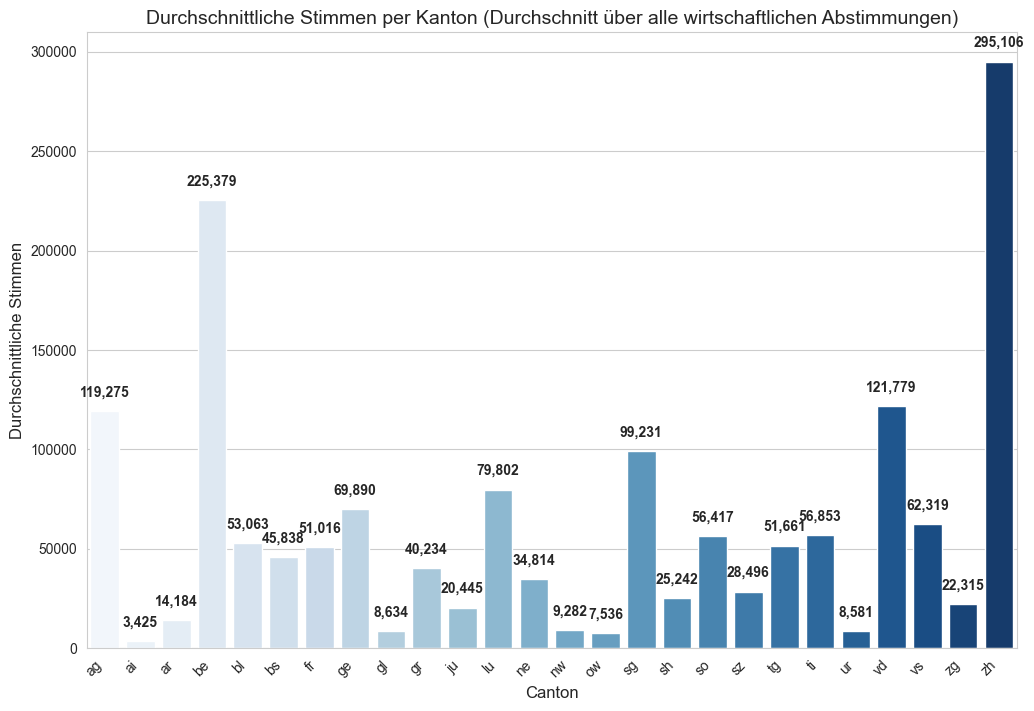

In [12]:
title = "Durchschnittliche Stimmen per Kanton (Durchschnitt über alle wirtschaftlichen Abstimmungen)"

# Create the figure
plt.figure(figsize=(12, 8))

# Create the bar plot
ax = sns.barplot(x=grouped_data.index, y=grouped_data.values, palette=color_palette)


for i, value in enumerate(grouped_data.values):
    # Format large numbers with thousands separator
    if value >= 1000:
        value_text = f"{value:,.0f}"
    else:
        value_text = f"{value:.1f}"

    ax.text(i, value + (grouped_data.max() * 0.02), value_text, 
           ha='center', va='bottom', fontweight='bold')

# Add labels and title
plt.xlabel('Canton', fontsize=12)
plt.ylabel(f"Durchschnittliche Stimmen", fontsize=12)
plt.title(title, fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Add count of data points per canton
canton_counts = df_agg_votes_stats_per_canton['canton'].value_counts()
for i, canton in enumerate(grouped_data.index):
    if canton in canton_counts:
        count = canton_counts[canton]


#### Kantone, die am öftesten wie die ganze Schweiz abgestummen haben

In [13]:
# Drop rows where 'volk_canton_aligned' is None
df_agg_votes_stats_per_canton = df_agg_votes_stats_per_canton.dropna(subset=['volk_canton_aligned'])

# Calculate alignment percentages
alignment_stats = df_agg_votes_stats_per_canton.groupby('canton')['volk_canton_aligned'].agg(['mean', 'count']).reset_index()
alignment_stats.columns = ['canton', 'alignment_rate', 'vote_count']
alignment_stats['alignment_percent'] = alignment_stats['alignment_rate'] * 100

# Sort by alignment rate
alignment_stats = alignment_stats.sort_values('alignment_rate', ascending=False).reset_index(drop=True)

print(alignment_stats)

   canton alignment_rate  vote_count alignment_percent
0      be       0.946429         112         94.642857
1      ag         0.9375         112             93.75
2      zh       0.928571         112         92.857143
3      so       0.910714         112         91.071429
4      bl       0.910714         112         91.071429
5      sh       0.901786         112         90.178571
6      lu       0.883929         112         88.392857
7      zg       0.883929         112         88.392857
8      sg       0.857143         112         85.714286
9      vd       0.848214         112         84.821429
10     ur       0.848214         112         84.821429
11     tg       0.848214         112         84.821429
12     gl       0.848214         112         84.821429
13     ge       0.848214         112         84.821429
14     ti       0.839286         112         83.928571
15     fr       0.839286         112         83.928571
16     ne       0.830357         112         83.035714
17     ar 

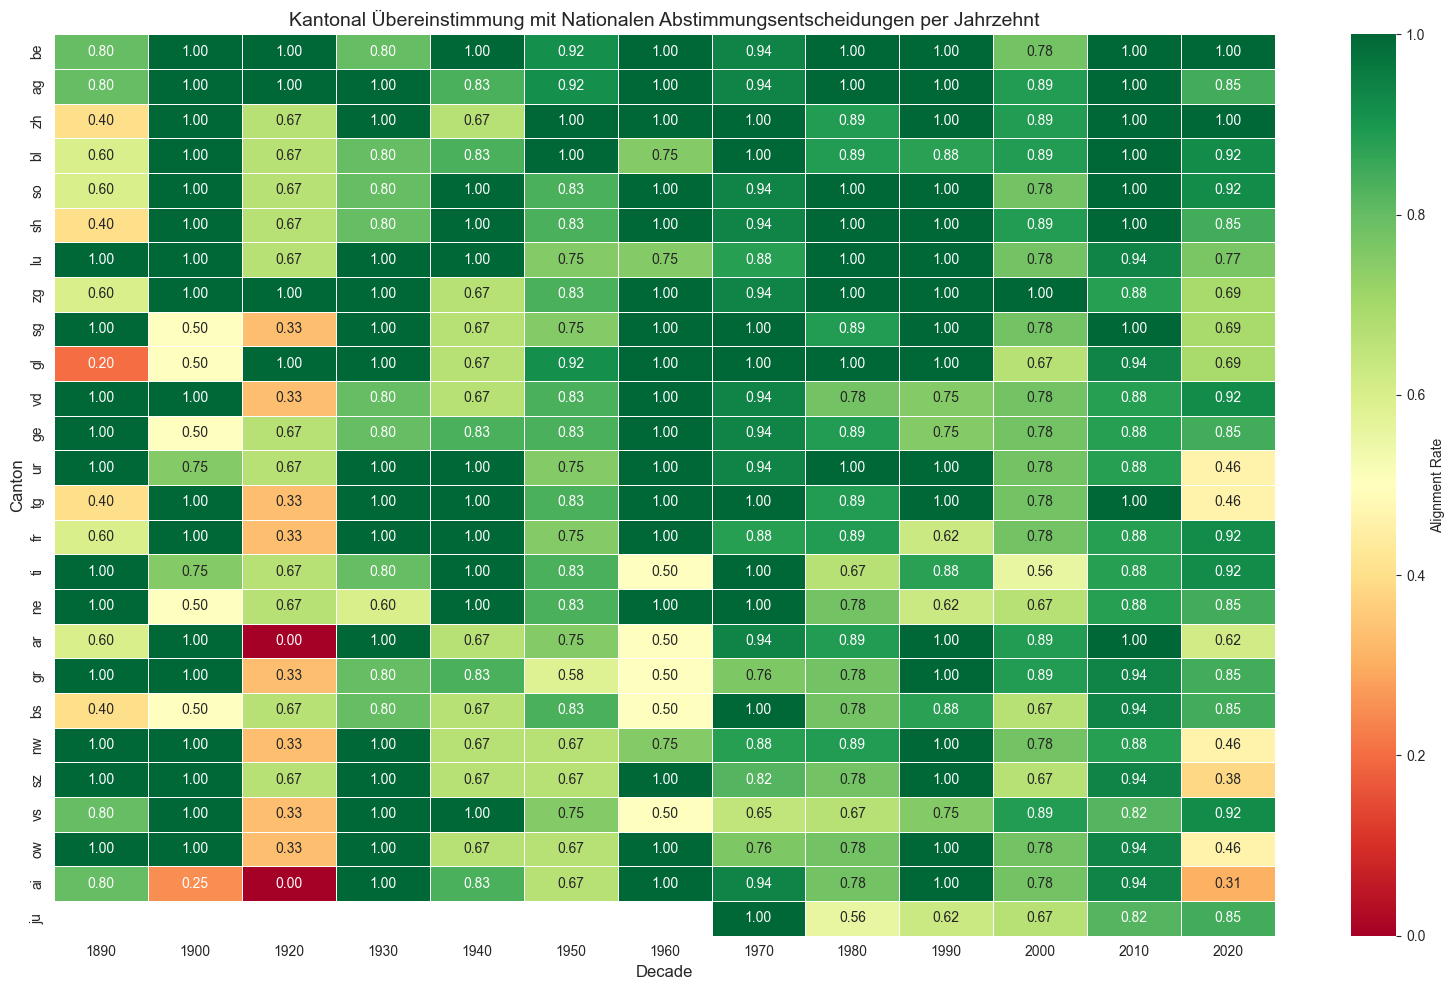

In [14]:
title = "Kantonal Übereinstimmung mit Nationalen Abstimmungsentscheidungen per Jahrzehnt"

# Ensure year is numeric
df_agg_votes_stats_per_canton['year'] = pd.to_numeric(df_agg_votes_stats_per_canton['year'], errors='coerce')

# Drop any rows with NaN years
df_agg_votes_stats_per_canton = df_agg_votes_stats_per_canton.dropna(subset=['year'])

# Create decade column (convert to int first to avoid error)
df_agg_votes_stats_per_canton['decade'] = (df_agg_votes_stats_per_canton['year'].astype(int) // 10) * 10

# Ensure the 'aligned' column is boolean or numeric
df_agg_votes_stats_per_canton['volk_canton_aligned'] = df_agg_votes_stats_per_canton['volk_canton_aligned'].astype(float)

# Calculate alignment rate by canton and decade
heatmap_data = df_agg_votes_stats_per_canton.groupby(['canton', 'decade'])['volk_canton_aligned'].mean().reset_index()

# Pivot for heatmap format
heatmap_pivot = heatmap_data.pivot(index='canton', columns='decade', values='volk_canton_aligned')

# Sort cantons by overall alignment rate
canton_order = df_agg_votes_stats_per_canton.groupby('canton')['volk_canton_aligned'].mean().sort_values(ascending=False).index
heatmap_pivot = heatmap_pivot.reindex(canton_order)

# Set Seaborn style
sns.set_style("white")

# Create the figure
plt.figure(figsize=(16, 10))

# Create the heatmap
ax = sns.heatmap(heatmap_pivot, annot=True, cmap='RdYlGn', vmin=0, vmax=1, 
                fmt='.2f', linewidths=0.5, cbar_kws={'label': 'Alignment Rate'})

# Add labels and title
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Canton', fontsize=12)
plt.title(title, fontsize=14)

plt.tight_layout()

## Prepare the data frame for the lin. reg. models

In [15]:
import re

# Function to convert religious to a continuous value
def religion_to_continuous(religion_str):
    if pd.isna(religion_str):
        return 0  # Neutral rating for unknown religious affiliation
    
    religion_lower = religion_str.lower()

    # If no exact match is found, try to determine the type based on keywords
    if 'katholisch' in religion_lower and '80' in religion_lower:
        continuous_scaled = -0.9  # Catholic as negative values
    elif 'reformiert' in religion_lower and '80' in religion_lower:
        continuous_scaled = 0.9  # Reformed as positive values
    elif 'katholisch' in religion_lower and '60' in religion_lower:
        continuous_scaled = -0.7  # Catholic as negative values
    elif 'reformiert' in religion_lower and '60' in religion_lower:
        continuous_scaled = 0.7  # Reformed as positive values
    elif 'katholisch' in religion_lower and '40' in religion_lower:
        continuous_scaled = -0.5  # Catholic as negative values
    elif 'reformiert' in religion_lower and '40' in religion_lower:
        continuous_scaled = 0.5  # Reformed as positive values
    elif 'anderer' in religion_lower or 'ohne' in religion_lower:
        continuous_scaled = 0 # All other religious 
    
    # Calculate the continuous value (between -1 and 1)
    return continuous_scaled

df_kanton_agg['religion_continuous'] = df_kanton_agg['Religion'].apply(religion_to_continuous)

print(df_kanton_agg)

    Kanton  Jahr                            Religion  religion_continuous
0       AG  1850       mehrheit katholisch: ≥ 80,0 %                 -0.9
1       AG  1860       mehrheit katholisch: ≥ 80,0 %                 -0.9
2       AG  1870       mehrheit katholisch: ≥ 80,0 %                 -0.9
3       AG  1880       mehrheit katholisch: ≥ 80,0 %                 -0.9
4       AG  1890       mehrheit katholisch: ≥ 80,0 %                 -0.9
..     ...   ...                                 ...                  ...
437     ZH  1970  mehrheit reformiert: 60,0 - 79,9 %                  0.7
438     ZH  1980  mehrheit reformiert: 60,0 - 79,9 %                  0.7
439     ZH  1990  mehrheit reformiert: 40,0 - 59,9 %                  0.5
440     ZH  2000  mehrheit reformiert: 40,0 - 59,9 %                  0.5
441     ZH  2014  mehrheit reformiert: 40,0 - 59,9 %                  0.5

[442 rows x 4 columns]


In [16]:
print(df_kanton_agg['religion_continuous'].unique())

[-0.9  0.9  0.7 -0.7 -0.5  0.5  0. ]


In [17]:
df_lin_reg_continuous_eco_votes = df_full_model_data

df_lin_reg_continuous_eco_votes['jahr'] = df_lin_reg_continuous_eco_votes['datum'].dt.year

votes = []

for id, vote in df_lin_reg_continuous_eco_votes.iterrows():
    # overall result vote
    vote_yes_percentage_overall_ch = float(vote['volkja-proz'])
    
    vote_count_valid_overall = float(vote['gultig'])

    # overall, is the vote economically beneficial
    economically_beneficial = vote['Wirtschaftsfördernd']
    
    reference_years = df_kanton_agg['Jahr'].unique()

    # Find the index of the nearest laying value
    idx = np.abs(reference_years - vote['jahr']).argmin()
    # get the year used for the political data
    religion_reference_year = reference_years[idx]

    # Get the religion information from the specified reference year
    df_kantons_reference_year = df_kanton_agg[df_kanton_agg['Jahr'] == religion_reference_year]
    
    # For each canton, check if it already existed at the time of the vote
    existing_cantons = df_kantons_reference_year[df_kantons_reference_year['Religion'].notna()]

    for idx, canton in existing_cantons.iterrows():
        
        canton_religion = canton['religion_continuous']

        canton_abbreviation = canton['Kanton'].lower()

        yes_percentage_canton = vote[f'{canton_abbreviation}-japroz']        

        # Get the percentage of votes from all votes in switzerland of that canton
        canton_vote_count_valid = float(vote[f'{canton_abbreviation}-gultig'])

        canton_national_vote_proportion = canton_vote_count_valid / vote_count_valid_overall

        votes.append({
            'vote_id': id,
            'voting_year': vote['jahr'],
            'canton': canton_abbreviation,
            'canton_national_vote_proportion': canton_national_vote_proportion,
            'yes_percentage': yes_percentage_canton,
            'economically_beneficial' : economically_beneficial
        })
        
    votes.append({
        'vote_id': id,
        'voting_year': vote['jahr'],
        'canton': 'Schweiz_Gesamt',
        'yes_percentage': vote_yes_percentage_overall_ch,
        'economically_beneficial' : economically_beneficial
    })
    
votes_df = pd.DataFrame(votes)

votes_df.head()

,vote_id,voting_year,canton,canton_national_vote_proportion,yes_percentage,economically_beneficial
0,40,1894,ag,0.105970,36.91,1
1,40,1894,ai,0.008610,12.40,1
2,40,1894,ar,0.026454,48.80,1
3,40,1894,be,0.140681,49.90,1
4,40,1894,bl,0.013830,43.30,1


In [18]:
# ------ Restructuring the data for modeling ------

# 1. Extract the overall results for Switzerland as the target variable
switzerland_overall = votes_df[votes_df['canton'] == 'Schweiz_Gesamt'].copy()
switzerland_overall['yes_percentage'] = switzerland_overall['yes_percentage'] / 100.0  # Normalize to 0-1
switzerland_overall['accepted'] = (switzerland_overall['yes_percentage'] >= 0.5).astype(int)  # Binary acceptance variable
switzerland_overall['economical_alignment'] = (switzerland_overall['accepted'] == switzerland_overall['economically_beneficial']).astype(int)

# 2. Remove the overall Swiss results from the voting data
cantonal_data = votes_df[votes_df['canton'] != 'Schweiz_Gesamt'].copy()

# 3. For each vote: Create features based on the religious profiles of the cantons
vote_features = []

for vote_id in cantonal_data['vote_id'].unique():
    # Data for this vote
    vote_data = cantonal_data[cantonal_data['vote_id'] == vote_id]
    voting_year = vote_data['voting_year'].iloc[0]
    
    # Create feature row for this vote
    feature_row = {'vote_id': vote_id, 'voting_year': voting_year}
    
    # Count cantons by religious affiliation
    religion_counts = {}
    religion_continuous_avg = 0
    existing_cantons = 0

    # Find the index of the nearest laying value
    idx = np.abs(reference_years - vote_data['voting_year'].unique()).argmin()
    # get the year used for the political data
    religion_reference_year = reference_years[idx]

    # Get the religion information from the specified reference year
    df_kantons_reference_year = df_kanton_agg[df_kanton_agg['Jahr'] == religion_reference_year]
    
    # For each canton, check if it already existed at the time of the vote
    available_cantons = df_kantons_reference_year[df_kantons_reference_year['Religion'].notna()]
    
    # For each canton that participated in the vote
    for id, canton in available_cantons.iterrows():
        religion = canton['Religion']
        religion_continuous = canton['religion_continuous']
        
        # Count the religion categories
        if religion not in religion_counts:
            religion_counts[religion] = 0
        religion_counts[religion] += 1
        
        # Add the continuous religion value for this canton
        feature_row[f'religion_{canton["Kanton"]}'] = religion_continuous
        religion_continuous_avg += religion_continuous
        existing_cantons += 1

        # Add the weighted continuous value for this canton
        cantonal_national_proportion = vote_data[vote_data['canton'] == canton["Kanton"].lower()]['canton_national_vote_proportion']
        religion_continuous_weigthed = float(religion_continuous * cantonal_national_proportion)
        feature_row[f'religion_{canton["Kanton"]}_weighted'] = religion_continuous_weigthed
    
    # Calculate the average continuous religion value
    if existing_cantons:
        feature_row['religion_continuous_avg'] = religion_continuous_avg / existing_cantons
    else:
        feature_row['religion_continuous_avg'] = 0
    
    # Add the number of cantons by religious category
    for religion, count in religion_counts.items():
        feature_row[f'count_{religion}'] = count

    # Add the number of existing cantons
    feature_row['num_cantone'] = existing_cantons
    
    vote_features.append(feature_row)

# Create DataFrame with features per vote
vote_features_df = pd.DataFrame(vote_features)

# 4. Connect the features with the target variables
model_data = pd.merge(vote_features_df, switzerland_overall[['vote_id', 'yes_percentage', 'accepted', 'economically_beneficial', 'economical_alignment']], on='vote_id')

model_data.head()

C:\Users\aaron\AppData\Local\Temp\ipykernel_22856\1120262364.py:56: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  religion_continuous_weigthed = float(religion_continuous * cantonal_national_proportion)


,vote_id,voting_year,religion_AG,religion_AG_weighted,religion_AI,religion_AI_weighted,religion_AR,religion_AR_weighted,religion_BE,religion_BE_weighted,...,"count_mehrheit katholisch: 60,0 - 79,9 %","count_mehrheit katholisch: 40,0 - 59,9 %","count_mehrheit reformiert: 40,0 - 59,9 %",religion_JU,religion_JU_weighted,"count_mehrheit mit anderer oder ohne religionszugehörigkeit: 40,0 - 59,9 %",yes_percentage,accepted,economically_beneficial,economical_alignment
0,40,1894,-0.9,-0.095373,-0.9,-0.007749,0.9,0.023809,0.9,0.126613,...,NaN,NaN,NaN,NaN,NaN,NaN,0.4613,0,1,0
1,41,1894,-0.9,-0.076469,-0.9,-0.005559,0.9,0.021485,0.9,0.147779,...,NaN,NaN,NaN,NaN,NaN,NaN,0.1975,0,0,1
2,44,1895,-0.9,-0.094293,-0.9,-0.006161,0.9,0.022972,0.9,0.118871,...,NaN,NaN,NaN,NaN,NaN,NaN,0.4323,0,1,0
3,49,1897,-0.9,-0.072971,-0.9,-0.004849,0.9,0.016950,0.9,0.135063,...,NaN,NaN,NaN,NaN,NaN,NaN,0.4333,0,1,0
4,51,1897,-0.9,-0.112035,-0.9,-0.006573,0.9,0.023417,0.9,0.149750,...,NaN,NaN,NaN,NaN,NaN,NaN,0.6511,1,1,1


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Model 1 - Kategorische features

In [22]:
# ------ Model 1: Categorical Model ------
# Here we use the number of cantons per religious category

# Identify columns that begin with "count_" (religion categories)
count_cols = [col for col in model_data.columns if col.startswith('count_')]

print(count_cols)

# Define feature columns for Model 1
X1_cols = ['num_cantone'] + count_cols
X1 = model_data[X1_cols].fillna(0)  # Fill missing values with 0
y = model_data['accepted'].astype(int)  # Target variable: Yes-share

# Split data into training and test sets
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

# Standardisierung der Daten (wichtig für logistische Regression)
scaler1 = StandardScaler()
X1_train_scaled = scaler1.fit_transform(X1_train)
X1_test_scaled = scaler1.transform(X1_test)

# Modell 1: Logistisches Modell mit kategorischer religiöser Zugehörigkeit
print("Modell 1: Logistisches Modell mit kategorischer religiöser Zugehörigkeit")
model1 = LogisticRegression(random_state=42, max_iter=1000)
model1.fit(X1_train_scaled, y_train)

# Evaluation des Modells 1
y_pred1 = model1.predict(X1_test_scaled)
y_pred_proba1 = model1.predict_proba(X1_test_scaled)[:, 1]

acc1 = accuracy_score(y_test, y_pred1)
conf_matrix1 = confusion_matrix(y_test, y_pred1)

print(f'Accuracy: {acc1:.4f}')
print("\nKonfusionsmatrix:")
print(conf_matrix1)
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred1))

# Koeffizienten analysieren
feature_names_1 = ['intercept'] + [col for col in model_data.columns if col.startswith('count_')]
coefs1 = pd.DataFrame({'Feature': feature_names_1, 'Koeffizient': model1.coef_[0]})
print("\nKoeffizienten des Modells 1 (Kategorisch):")
print(coefs1)

['count_mehrheit katholisch: ≥ 80,0 %', 'count_mehrheit reformiert: ≥ 80,0 %', 'count_mehrheit reformiert: 60,0 - 79,9 %', 'count_mehrheit katholisch: 60,0 - 79,9 %', 'count_mehrheit katholisch: 40,0 - 59,9 %', 'count_mehrheit reformiert: 40,0 - 59,9 %', 'count_mehrheit mit anderer oder ohne religionszugehörigkeit: 40,0 - 59,9 %']
Modell 1: Logistisches Modell mit kategorischer religiöser Zugehörigkeit
Accuracy: 0.5652

Konfusionsmatrix:
[[9 3]
 [7 4]]

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.56      0.75      0.64        12
           1       0.57      0.36      0.44        11

    accuracy                           0.57        23
   macro avg       0.57      0.56      0.54        23
weighted avg       0.57      0.57      0.55        23


Koeffizienten des Modells 1 (Kategorisch):
                                             Feature  Koeffizient
0                                          intercept    -0.743979
1              

### Model 2 - Continuous features (Religionszugehörigkeit der Kantone als Input Features (X) und Prozentuale Ja-Stimmen des ganzen Volkes als y)

In [ ]:
# ------ Model 2: Continuous Model ------
# Here we use the continuous religion value and the average value

X2_cols = ['religion_AG', 'religion_AI', 'religion_AR', 'religion_BE', 'religion_BL', 'religion_BS', 'religion_FR', 'religion_GE', 'religion_ZH', 'religion_ZG',
          'religion_SO', 'religion_TI', 'religion_VS', 'religion_NE', 'religion_OW', 'religion_NW', 'religion_SG', 'religion_TG', 'religion_GR', 'religion_SH', 'religion_VD',
          'religion_UR', 'religion_LU', 'religion_SZ']

X2 = model_data[X2_cols].fillna(0)  # Fill missing values with 0

# Split data into training and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, random_state=42)

# Modell 2: Logistisches Modell mit kontinuierlichem religiösem Wert
print("\nModell 2: Logistisches Modell mit kontinuierlichem religiösem Wert (-1 bis 1)")
model2 = LogisticRegression(random_state=42, max_iter=1000) 
model2.fit(X2_train, y2_train)

# Evaluate the model
y_pred2 = model2.predict(X2_test)
y_pred2_clipped = np.clip(y_pred2, 0, 1)  # Limit predictions to [0,1]
mse2 = mean_squared_error(y2_test, y_pred2_clipped)
r2_2 = r2_score(y2_test, y_pred2_clipped)

print("\nModel 2 (Continuous Model):")
print(f"Mean Squared Error: {mse2:.4f}")
print(f"R²-Score: {r2_2:.4f}")

print(model2.coef_)
print(X2_cols)

# Analyze coefficients
coefs2 = pd.DataFrame({'Feature': X2_cols, 'Coefficient': model2.coef_[0]})
print("\nCoefficients of Model 2:")
print(coefs2)

### Model 3 - Continuous features (Religionszugehörigkeit der Kantone als Input Features (X) und Vorschlag der FDP als y (Ja = 1 oder Nein = 2, andere Werte werden gefiltert))

In [ ]:
# ------ Model 3: Continuous Model (y variable is the alignment of the vote is it enconomically beneficial or not) ------
# Here we use the continuous religion value

X3_cols = ['religion_AG', 'religion_AI', 'religion_AR', 'religion_BE', 'religion_BL', 'religion_BS', 'religion_FR', 'religion_GE', 'religion_ZH', 'religion_ZG',
          'religion_SO', 'religion_TI', 'religion_VS', 'religion_NE', 'religion_OW', 'religion_NW', 'religion_SG', 'religion_TG', 'religion_GR', 'religion_SH', 'religion_VD',
          'religion_UR', 'religion_LU', 'religion_SZ']

X3 = model_data[X3_cols].fillna(0)  # Fill missing values with 0

y3 = model_data['economically_beneficial'].astype(int)  # Target variable: Yes-share

# Split data into training and test sets
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

# Modell 2: Logistisches Modell mit kontinuierlichem religiösem Wert
print("\nModell 3: Logistisches Modell mit kontinuierlichem religiösem Wert (-1 bis 1), Die Vorhersage sagt aus ob eine Abstimmung wirtschaftsfördernd oder ablehnend ist")
model3 = LogisticRegression(random_state=42, max_iter=1000) 
model3.fit(X3_train, y3_train)

# Evaluate the model
y_pred3 = model3.predict(X3_test)
y_pred3_clipped = np.clip(y_pred3, 0, 1)  # Limit predictions to [0,1]
mse3 = mean_squared_error(y3_test, y_pred3_clipped)
r2_3 = r2_score(y3_test, y_pred3_clipped)

print("\nModel 3 (Continuous Model):")
print(f"Mean Squared Error: {mse3:.4f}")
print(f"R²-Score: {r2_3:.4f}")

print(model3.coef_)
print(X3_cols)

# Analyze coefficients
coefs3 = pd.DataFrame({'Feature': X3_cols, 'Coefficient': model3.coef_[0]})
print("\nCoefficients of Model 3:")
print(coefs3)

### Model 4 - Continuous features (Weigthed Religionszugehörigkeit der Kantone als Input Features (X) und Vorschlag der FDP als y (Ja = 1 oder Nein = 2, andere Werte werden gefiltert))

In [ ]:
X4_cols = ['religion_AG_weighted', 'religion_AI_weighted', 'religion_AR_weighted', 'religion_BE_weighted', 'religion_BL_weighted', 'religion_BS_weighted', 'religion_FR_weighted', 'religion_GE_weighted', 'religion_ZH_weighted', 'religion_ZG_weighted',
          'religion_SO_weighted', 'religion_TI_weighted', 'religion_VS_weighted', 'religion_NE_weighted', 'religion_OW_weighted', 'religion_NW_weighted', 'religion_SG_weighted', 'religion_TG_weighted', 'religion_GR_weighted', 'religion_SH_weighted', 'religion_VD_weighted',
          'religion_UR_weighted', 'religion_LU_weighted', 'religion_SZ_weighted']

X4 = model_data[X4_cols].fillna(0)  # Fill missing values with 0

y4 = model_data['economically_beneficial'].astype(int)  # Target variable: Yes-share

# Split data into training and test sets
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42)

# Modell 2: Logistisches Modell mit kontinuierlichem religiösem Wert
print("\nModell 4: Logistisches Modell mit kontinuierlichem religiösem Wert (-1 bis 1), Die Vorhersage sagt aus ob eine Abstimmung wirtschaftsfördernd oder ablehnend ist")
model4 = LogisticRegression(random_state=42, max_iter=1000) 
model4.fit(X4_train, y4_train)

# Evaluate the model
y_pred4 = model4.predict(X4_test)
y_pred4_clipped = np.clip(y_pred4, 0, 1)  # Limit predictions to [0,1]
mse4 = mean_squared_error(y4_test, y_pred4_clipped)
r2_4 = r2_score(y4_test, y_pred4_clipped)

print("\nModel 4 (Weighted Continuous Model):")
print(f"Mean Squared Error: {mse4:.4f}")
print(f"R²-Score: {r2_4:.4f}")

print(model4.coef_)
print(X4_cols)

# Analyze coefficients
coefs4 = pd.DataFrame({'Feature': X4_cols, 'Coefficient': model4.coef_[0]})
print("\nCoefficients of Model 4:")
print(coefs4)

### Model 5 - Continuous features (Weigthed Religionszugehörigkeit der Kantone als Input Features (X) und y als ökonomischer Ausrichtung (Empfehlung der FDP und Abstimmungsresultat stimmen überein))

In [ ]:
X5_cols = ['religion_AG_weighted', 'religion_AI_weighted', 'religion_AR_weighted', 'religion_BE_weighted', 'religion_BL_weighted', 'religion_BS_weighted', 'religion_FR_weighted', 'religion_GE_weighted', 'religion_ZH_weighted', 'religion_ZG_weighted',
          'religion_SO_weighted', 'religion_TI_weighted', 'religion_VS_weighted', 'religion_NE_weighted', 'religion_OW_weighted', 'religion_NW_weighted', 'religion_SG_weighted', 'religion_TG_weighted', 'religion_GR_weighted', 'religion_SH_weighted', 'religion_VD_weighted',
          'religion_UR_weighted', 'religion_LU_weighted', 'religion_SZ_weighted']

X5 = model_data[X5_cols].fillna(0)  # Fill missing values with 0

y5 = model_data['economical_alignment'].astype(int)  # Target variable: Yes-share

# Split data into training and test sets
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=42)

# Modell 2: Logistisches Modell mit kontinuierlichem religiösem Wert
print("\nModell 5: Logistisches Modell mit kontinuierlichem religiösem Wert (-1 bis 1), Die Vorhersage sagt ökonomischer Ausrichtung aus (Empfehlung der FDP und Abstimmungsresultat stimmen überein)")
model5 = LogisticRegression(random_state=42, max_iter=1000) 
model5.fit(X5_train, y5_train)

# Evaluate the model
y_pred5 = model5.predict(X5_test)
y_pred5_clipped = np.clip(y_pred5, 0, 1)  # Limit predictions to [0,1]
mse5 = mean_squared_error(y5_test, y_pred5_clipped)
r2_5 = r2_score(y5_test, y_pred5_clipped)

print("\nModel 5 (Weighted Continuous Model with adjusted y):")
print(f"Mean Squared Error: {mse5:.4f}")
print(f"R²-Score: {r2_5:.4f}")

print(model5.coef_)
print(X5_cols)

# Analyze coefficients
coefs5 = pd.DataFrame({'Feature': X5_cols, 'Coefficient': model5.coef_[0]})
print("\nCoefficients of Model 5:")
print(coefs5)

### Evaluation of the models

In [ ]:
# Evaluation of the model 1
y_pred1 = model1.predict(X1_test_scaled)
y_pred_proba1 = model1.predict_proba(X1_test_scaled)[:, 1]

acc1 = accuracy_score(y_test, y_pred1)
conf_matrix1 = confusion_matrix(y_test, y_pred1)

# Evaluation des Modells 2
y_pred2 = model2.predict(X2_test)
y_pred_proba2 = model2.predict_proba(X2_test)[:, 1]

acc2 = accuracy_score(y2_test, y_pred2)
conf_matrix2 = confusion_matrix(y2_test, y_pred2)

# Evaluation des Modells 3
y_pred3 = model3.predict(X3_test)
y_pred_proba3 = model3.predict_proba(X3_test)[:, 1]

acc3 = accuracy_score(y3_test, y_pred3)
conf_matrix3 = confusion_matrix(y3_test, y_pred3)

# Evaluation des Modells 4
y_pred4 = model4.predict(X4_test)
y_pred_proba4 = model4.predict_proba(X4_test)[:, 1]

acc4 = accuracy_score(y4_test, y_pred4)
conf_matrix4 = confusion_matrix(y4_test, y_pred4)

# Evaluation des Modells 5
y_pred5 = model5.predict(X5_test)
y_pred_proba5 = model5.predict_proba(X5_test)[:, 1]

acc5 = accuracy_score(y5_test, y_pred5)
conf_matrix5 = confusion_matrix(y5_test, y_pred5)

### Visualizations

In [ ]:
# ------ Visualization ------
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Modell 1: ROC-Kurve
plt.subplot(1, 2, 1)
fpr1, tpr1, _ = roc_curve(y_test, y_pred_proba1)
roc_auc1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, label=f'ROC-Kurve (AUC = {roc_auc1:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsch-Positiv-Rate')
plt.ylabel('Richtig-Positiv-Rate')
plt.title('ROC-Kurve für Modell 1 (Kategorisch)')
plt.legend(loc="lower right")
plt.grid(True)

# Modell 2: ROC-Kurve
plt.subplot(1, 2, 2)
fpr2, tpr2, _ = roc_curve(y2_test, y_pred_proba2)
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label=f'ROC-Kurve (AUC = {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsch-Positiv-Rate')
plt.ylabel('Richtig-Positiv-Rate')
plt.title('ROC-Kurve für Modell 2 (Kontinuierlich)')
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()

plt.figure(figsize=(15, 5))

# Modell 3: ROC-Kurve
plt.subplot(1, 2, 1)
fpr3, tpr3, _ = roc_curve(y3_test, y_pred_proba3)
roc_auc3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label=f'ROC-Kurve (AUC = {roc_auc3:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsch-Positiv-Rate')
plt.ylabel('Richtig-Positiv-Rate')
plt.title('ROC-Kurve für Modell 3 (Kontinuerlich angepasste Y-Variable)')
plt.legend(loc="lower right")
plt.grid(True)

# Modell 4: ROC-Kurve
plt.subplot(1, 2, 2)
fpr4, tpr4, _ = roc_curve(y4_test, y_pred_proba4)
roc_auc4 = auc(fpr4, tpr4)
plt.plot(fpr4, tpr4, label=f'ROC-Kurve (AUC = {roc_auc4:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsch-Positiv-Rate')
plt.ylabel('Richtig-Positiv-Rate')
plt.title('ROC-Kurve für Modell 4 (Gewichtet Kontinuerlich angepasste Y-Variable)')
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()

# Modell 4: ROC-Kurve
plt.figure(figsize=(8, 5))
fpr5, tpr5, _ = roc_curve(y5_test, y_pred_proba5)
roc_auc5 = auc(fpr5, tpr5)
plt.plot(fpr5, tpr5, label=f'ROC-Kurve (AUC = {roc_auc5:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsch-Positiv-Rate')
plt.ylabel('Richtig-Positiv-Rate')
plt.title('ROC-Kurve für Modell 5 (Gewichtet Kontinuerlich, angepasste Y-Variable (ökonomische Ausrichtung))')
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()

plt.figure(figsize=(15, 5))

# Einfluss der durchschnittliche kontinuierlichen religiösen Zugehörigkeit auf die Abstimmungsentscheidung
plt.subplot(2, 3, 1)
sns.regplot(x='religion_continuous_avg', y='accepted', data=model_data, logistic=True, 
           scatter_kws={'alpha': 0.3}, ci=None)
plt.xlabel('Religiöse Zugehörigkeit (-1 = katholisch, 1 = reformiert)')
plt.ylabel('Wahrscheinlichkeit einer Ja-Entscheidung')
plt.title('Einfluss der religiösen Zugehörigkeit auf die Abstimmungsentscheidung')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)

# Einfluss der durchschnittliche kontinuierlichen religiösen Zugehörigkeit auf die Empfehlung der FDP
plt.subplot(2, 3, 2)
sns.regplot(x='religion_continuous_avg', y='economically_beneficial', data=model_data, logistic=True, 
           scatter_kws={'alpha': 0.3}, ci=None)
plt.xlabel('Religiöse Zugehörigkeit (-1 = katholisch, 1 = reformiert)')
plt.ylabel('Wahrscheinlichkeit einer Ja-Entscheidung')
plt.title('Einfluss der religiösen Zugehörigkeit auf die Abstimmungsentscheidung')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)

# Einfluss der durchschnittliche kontinuierlichen religiösen Zugehörigkeit auf die wirtschaftliche Ausrichtung (FDP Empfehlung und das Abstimmungsresultat) 
plt.subplot(2, 3, 3)
sns.regplot(x='religion_continuous_avg', y='economical_alignment', data=model_data, logistic=True, 
           scatter_kws={'alpha': 0.3}, ci=None)
plt.xlabel('Religiöse Zugehörigkeit (-1 = katholisch, 1 = reformiert)')
plt.ylabel('Wahrscheinlichkeit ökonomischer Ausrichtung')
plt.title('Einfluss der religiösen Zugehörigkeit auf die ökonomische Ausrichtung')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)

plt.tight_layout()

# ------ Vergleich der Konfusionsmatrizen ------

plt.figure(figsize=(15, 5))

# Modell 1: Konfusionsmatrix
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Ablehnung', 'Annahme'], 
           yticklabels=['Ablehnung', 'Annahme'])
plt.xlabel('Vorhergesagt')
plt.ylabel('Tatsächlich')
plt.title('Konfusionsmatrix Modell 1 (Kategorisch)')

# Modell 2: Konfusionsmatrix
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Ablehnung', 'Annahme'], 
           yticklabels=['Ablehnung', 'Annahme'])
plt.xlabel('Vorhergesagt')
plt.ylabel('Tatsächlich')
plt.title('Konfusionsmatrix Modell 2 (Kontinuierlich)')


plt.tight_layout()


plt.figure(figsize=(15, 5))

# Modell 3: Konfusionsmatrix
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix3, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Empf. Ablehnung', 'Empf. Annahme'], 
           yticklabels=['Empf. Ablehnung', 'Empf. Annahme'])
plt.xlabel('Vorhergesagt')
plt.ylabel('Tatsächlich')
plt.title('Konfusionsmatrix Modell 3 (Kontinuierlich, angepasstes Y)')

# Modell 4: Konfusionsmatrix
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix4, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Empf. Ablehnung', 'Empf. Annahme'], 
           yticklabels=['Empf. Ablehnung', 'Empf. Annahme'])
plt.xlabel('Vorhergesagt')
plt.ylabel('Tatsächlich')
plt.title('Konfusionsmatrix Modell 4 (Gewichtet Kontinuierlich, angepasstes Y)')


plt.tight_layout()

plt.figure(figsize=(8, 5))

# Modell 5: Konfusionsmatrix
sns.heatmap(conf_matrix5, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Nicht wirtschaftlich ausgerichtet', 'Wirtschaftlich ausgerichtet'], 
           yticklabels=['Nicht wirtschaftlich ausgerichtet', 'Wirtschaftlich ausgerichtet'])
plt.xlabel('Vorhergesagt')
plt.ylabel('Tatsächlich')
plt.title('Konfusionsmatrix Modell 5 (Gewichtet Kontinuierlich, angepasstes y (Wirtschaftlich ausgerichtet))')

plt.tight_layout()

In [ ]:
# ------ helper function to get all continuous values for all cantons

def get_continuous_values_for_cantons(current_cantons):
    # Calculate the average continuous religion value
    religion_continuous_avg = current_cantons['religion_continuous'].mean()

    religion_AG_continuous = current_cantons[current_cantons['Kanton'] == 'AG']['religion_continuous'].values[0]
    religion_AI_continuous = current_cantons[current_cantons['Kanton'] == 'AI']['religion_continuous'].values[0]
    religion_AR_continuous = current_cantons[current_cantons['Kanton'] == 'AR']['religion_continuous'].values[0]
    religion_BE_continuous = current_cantons[current_cantons['Kanton'] == 'BE']['religion_continuous'].values[0]
    religion_BL_continuous = current_cantons[current_cantons['Kanton'] == 'BL']['religion_continuous'].values[0]
    religion_BS_continuous = current_cantons[current_cantons['Kanton'] == 'BS']['religion_continuous'].values[0]
    religion_FR_continuous = current_cantons[current_cantons['Kanton'] == 'FR']['religion_continuous'].values[0]
    religion_GE_continuous = current_cantons[current_cantons['Kanton'] == 'GE']['religion_continuous'].values[0]
    religion_ZH_continuous = current_cantons[current_cantons['Kanton'] == 'ZH']['religion_continuous'].values[0]
    religion_ZG_continuous = current_cantons[current_cantons['Kanton'] == 'ZG']['religion_continuous'].values[0]
    religion_SO_continuous = current_cantons[current_cantons['Kanton'] == 'SO']['religion_continuous'].values[0]
    religion_TI_continuous = current_cantons[current_cantons['Kanton'] == 'TI']['religion_continuous'].values[0]
    religion_VS_continuous = current_cantons[current_cantons['Kanton'] == 'VS']['religion_continuous'].values[0]
    religion_NE_continuous = current_cantons[current_cantons['Kanton'] == 'NE']['religion_continuous'].values[0]
    religion_OW_continuous = current_cantons[current_cantons['Kanton'] == 'OW']['religion_continuous'].values[0]
    religion_NW_continuous = current_cantons[current_cantons['Kanton'] == 'NW']['religion_continuous'].values[0]
    religion_SG_continuous = current_cantons[current_cantons['Kanton'] == 'SG']['religion_continuous'].values[0]
    religion_TG_continuous = current_cantons[current_cantons['Kanton'] == 'TG']['religion_continuous'].values[0]
    religion_GR_continuous = current_cantons[current_cantons['Kanton'] == 'GR']['religion_continuous'].values[0]
    religion_SH_continuous = current_cantons[current_cantons['Kanton'] == 'SH']['religion_continuous'].values[0]
    religion_VD_continuous = current_cantons[current_cantons['Kanton'] == 'VD']['religion_continuous'].values[0]
    religion_UR_continuous = current_cantons[current_cantons['Kanton'] == 'UR']['religion_continuous'].values[0]
    religion_LU_continuous = current_cantons[current_cantons['Kanton'] == 'LU']['religion_continuous'].values[0]
    religion_SZ_continuous = current_cantons[current_cantons['Kanton'] == 'SZ']['religion_continuous'].values[0]

    return [
        religion_continuous_avg, religion_AG_continuous, religion_AI_continuous, religion_AR_continuous, religion_BE_continuous, religion_BL_continuous, religion_BS_continuous,
        religion_FR_continuous, religion_GE_continuous, religion_ZH_continuous, religion_ZG_continuous, religion_SO_continuous, religion_TI_continuous, religion_VS_continuous, religion_NE_continuous, 
        religion_OW_continuous, religion_NW_continuous, religion_SG_continuous, religion_TG_continuous, religion_GR_continuous, religion_SH_continuous, religion_VD_continuous, religion_UR_continuous, 
        religion_LU_continuous, religion_SZ_continuous
    ]

def get_weighted_continuous_values_for_cantons(current_cantons):
    example_proportions = votes_df[votes_df['vote_id'] == 400]
    
    religion_AG_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'AG']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'ag']['canton_national_vote_proportion'].values[0]
    religion_AI_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'AI']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'ai']['canton_national_vote_proportion'].values[0]
    religion_AR_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'AR']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'ar']['canton_national_vote_proportion'].values[0]
    religion_BE_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'BE']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'be']['canton_national_vote_proportion'].values[0]
    religion_BL_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'BL']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'bl']['canton_national_vote_proportion'].values[0]
    religion_BS_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'BS']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'bs']['canton_national_vote_proportion'].values[0]
    religion_FR_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'FR']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'fr']['canton_national_vote_proportion'].values[0]
    religion_GE_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'GE']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'ge']['canton_national_vote_proportion'].values[0]
    religion_ZH_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'ZH']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'zh']['canton_national_vote_proportion'].values[0]
    religion_ZG_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'ZG']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'zg']['canton_national_vote_proportion'].values[0]
    religion_SO_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'SO']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'so']['canton_national_vote_proportion'].values[0]
    religion_TI_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'TI']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'ti']['canton_national_vote_proportion'].values[0]
    religion_VS_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'VS']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'vs']['canton_national_vote_proportion'].values[0]
    religion_NE_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'NE']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'ne']['canton_national_vote_proportion'].values[0]
    religion_OW_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'OW']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'ow']['canton_national_vote_proportion'].values[0]
    religion_NW_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'NW']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'nw']['canton_national_vote_proportion'].values[0]
    religion_SG_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'SG']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'sg']['canton_national_vote_proportion'].values[0]
    religion_TG_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'TG']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'tg']['canton_national_vote_proportion'].values[0]
    religion_GR_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'GR']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'gr']['canton_national_vote_proportion'].values[0]
    religion_SH_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'SH']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'sh']['canton_national_vote_proportion'].values[0]
    religion_VD_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'VD']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'vd']['canton_national_vote_proportion'].values[0]
    religion_UR_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'UR']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'ur']['canton_national_vote_proportion'].values[0]
    religion_LU_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'LU']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'lu']['canton_national_vote_proportion'].values[0]
    religion_SZ_continuous_weighted = current_cantons[current_cantons['Kanton'] == 'SZ']['religion_continuous'].values[0] * example_proportions[example_proportions['canton'] == 'sz']['canton_national_vote_proportion'].values[0]
 
    return [
        religion_AG_continuous_weighted, religion_AI_continuous_weighted, religion_AR_continuous_weighted, religion_BE_continuous_weighted, religion_BL_continuous_weighted, religion_BS_continuous_weighted,
        religion_FR_continuous_weighted, religion_GE_continuous_weighted, religion_ZH_continuous_weighted, religion_ZG_continuous_weighted, religion_SO_continuous_weighted, religion_TI_continuous_weighted, religion_VS_continuous_weighted, religion_NE_continuous_weighted, 
        religion_OW_continuous_weighted, religion_NW_continuous_weighted, religion_SG_continuous_weighted, religion_TG_continuous_weighted, religion_GR_continuous_weighted, religion_SH_continuous_weighted, religion_VD_continuous_weighted, religion_UR_continuous_weighted, 
        religion_LU_continuous_weighted, religion_SZ_continuous_weighted
    ]
        
# ------ Prediction function ------

def predict_vote_outcome(model, model_type, current_cantons, verbose=True):
    """
    Predicts the outcome of a vote based on the current religious
    composition of the cantons.
    
    Parameters:
    model - The trained model
    model_type - 'categorical', 'continuous' or 'adj. continuous'
    current_cantons - DataFrame with current canton data
    verbose - Whether to display detailed output
    
    Returns:
    Predicted yes-share (0-1)
    """
    if model_type == 'categorical':
        # Create features for the categorical model
        religion_counts = current_cantons['Religion'].value_counts().to_dict()
        features = {'num_cantone': len(current_cantons)}
        
        for religion, count in religion_counts.items():
            features[f'count_{religion}'] = count
            
        # Create feature array (with the same columns as in the training model)
        X_pred = np.zeros(len(X1_cols))
        for i, col in enumerate(X1_cols):
            if col in features:
                X_pred[i] = features[col]
        
        # Make prediction
        predictions = model.predict([X_pred])[0]
        predictions = max(0, min(1, predictions))  # Limit to [0,1]
        
    elif model_type == 'continuous':
        # Calculate the average continuous religion value
        
        X2_cols = ['religion_continuous_avg', 'religion_AG', 'religion_AI', 'religion_AR', 'religion_BE', 'religion_BL', 'religion_BS', 'religion_FR', 'religion_GE', 'religion_ZH', 'religion_ZG',
          'religion_SO', 'religion_TI', 'religion_VS', 'religion_NE', 'religion_OW', 'religion_NW', 'religion_SG', 'religion_TG', 'religion_GR', 'religion_SH', 'religion_VD',
          'religion_UR', 'religion_LU', 'religion_SZ']
        
        # Create features for the continuous model
        # We use the current year and the current number of cantons
        features = get_continuous_values_for_cantons(current_cantons)[1:]
        
        # Make prediction
        predictions = model.predict([features])[0]
        predictions = max(0, min(1, predictions))  # Limit to [0,1]
        
    elif model_type == 'adj. continuous':
        # Calculate the average continuous religion value
        
        X3_cols = ['religion_AG', 'religion_AI', 'religion_AR', 'religion_BE', 'religion_BL', 'religion_BS', 'religion_FR', 'religion_GE', 'religion_ZH', 'religion_ZG',
          'religion_SO', 'religion_TI', 'religion_VS', 'religion_NE', 'religion_OW', 'religion_NW', 'religion_SG', 'religion_TG', 'religion_GR', 'religion_SH', 'religion_VD',
          'religion_UR', 'religion_LU', 'religion_SZ']
        
        # Create features for the continuous model
        # We use the current year and the current number of cantons
        features = get_continuous_values_for_cantons(current_cantons)[1:]
        
        # Make prediction
        predictions = model.predict([features])[0]
        predictions = max(0, min(1, predictions))  # Limit to [0,1]

        
    elif model_type == 'weighted adj. continuous':
        # Calculate the average continuous religion value
        
        X3_cols = ['religion_AG_weighted', 'religion_AI_weighted', 'religion_AR_weighted', 'religion_BE_weighted', 'religion_BL_weighted', 'religion_BS_weighted', 'religion_FR_weighted', 'religion_GE_weighted', 'religion_ZH_weighted', 'religion_ZG_weighted',
          'religion_SO_weighted', 'religion_TI_weighted', 'religion_VS_weighted', 'religion_NE_weighted', 'religion_OW_weighted', 'religion_NW_weighted', 'religion_SG_weighted', 'religion_TG_weighted', 'religion_GR_weighted', 'religion_SH_weighted', 'religion_VD_weighted',
          'religion_UR_weighted', 'religion_LU_weighted', 'religion_SZ_weighted']
        
        # Create features for the continuous model
        # We use the current year and the current number of cantons
        features = get_weighted_continuous_values_for_cantons(current_cantons)
        
        # Make prediction
        predictions = model.predict([features])[0]
        predictions = max(0, min(1, predictions))  # Limit to [0,1]

    elif model_type == "weighted continuous (y = economically alignment)":
        # Calculate the average continuous religion value
        
        X3_cols = ['religion_AG_weighted', 'religion_AI_weighted', 'religion_AR_weighted', 'religion_BE_weighted', 'religion_BL_weighted', 'religion_BS_weighted', 'religion_FR_weighted', 'religion_GE_weighted', 'religion_ZH_weighted', 'religion_ZG_weighted',
          'religion_SO_weighted', 'religion_TI_weighted', 'religion_VS_weighted', 'religion_NE_weighted', 'religion_OW_weighted', 'religion_NW_weighted', 'religion_SG_weighted', 'religion_TG_weighted', 'religion_GR_weighted', 'religion_SH_weighted', 'religion_VD_weighted',
          'religion_UR_weighted', 'religion_LU_weighted', 'religion_SZ_weighted']
        
        # Create features for the continuous model
        # We use the current year and the current number of cantons
        features = get_weighted_continuous_values_for_cantons(current_cantons)
        
        # Make prediction
        predictions = model.predict([features])[0]
        predictions = max(0, min(1, predictions))  # Limit to [0,1]


    return predictions

In [ ]:
# Example: Prediction with the current state of the cantons

# Find the religious information of the next reference year
# Find the index of the nearest laying value
idx = np.abs(reference_years - 1990).argmin()
# get the year used for the political data
religion_reference_year = reference_years[idx]
# Get the religion information from the specified reference year
df_kantons_reference_year = df_kanton_agg[df_kanton_agg['Jahr'] == religion_reference_year]
# For each canton, check if it already existed at the time of the vote
available_cantons = df_kantons_reference_year[df_kantons_reference_year['Religion'].notna()]

print("\n--- Prediction with current canton data ---")
print("Model 1 (Categorial): ", predict_vote_outcome(model1, 'categorical', available_cantons))
print("Model 2 (Continuous): ", predict_vote_outcome(model2, 'continuous', available_cantons))
print("Model 3 (adj. Continuous): ", predict_vote_outcome(model3, 'adj. continuous', available_cantons))
print("Model 4 (weigthed adj. Continuous): ", predict_vote_outcome(model4, 'weighted adj. continuous', available_cantons))
print("Model 5 (weighted continuous (y = economically alignment)): ", predict_vote_outcome(model5, 'weighted continuous (y = economically alignment)', available_cantons))

# ------ Example: What-if analysis ------

print("\n--- What-if analysis ---")

print("\nAssuming all cantons were predominantly Reformed:")

# Create a copy of the current canton data
reformierte_kantone = available_cantons.copy()
# Set all cantons to 'Majority Reformed: ≥ 80.0 %'
reformierte_kantone['Religion'] = 'Mehrheit reformiert: ≥ 80,0 %'
# Recalculate continuous values
reformierte_kantone['religion_continuous'] = reformierte_kantone['Religion'].apply(religion_to_continuous)
# Prediction with the assumed data
print("\nPrediction if all cantons were predominantly Reformed:")
print("Model 1 (Categorial): ", predict_vote_outcome(model1, 'categorical', reformierte_kantone))
print("Model 2 (Continuous): ", predict_vote_outcome(model2, 'continuous', reformierte_kantone))
print("Model 3 (adj. Continuous): ", predict_vote_outcome(model3, 'adj. continuous', reformierte_kantone))
print("Model 4 (weigthed adj. Continuous): ", predict_vote_outcome(model4, 'weighted adj. continuous', reformierte_kantone))
print("Model 5 (weighted continuous (y = economically alignment)): ", predict_vote_outcome(model5, 'weighted continuous (y = economically alignment)', reformierte_kantone))

print("\nAssuming all cantons were predominantly Catholic:")

# Create a copy of the current canton data
katholische_kantone = available_cantons.copy()
# Set all cantons to 'Majority Catholic: ≥ 80.0 %'
katholische_kantone['Religion'] = 'Mehrheit katholisch: ≥ 80,0 %'
# Recalculate continuous values
katholische_kantone['religion_continuous'] = katholische_kantone['Religion'].apply(religion_to_continuous)

# Prediction with the assumed data
print("\nPrediction if all cantons were predominantly Catholic:")
print("Model 1 (Categorial): ", predict_vote_outcome(model1, 'categorical', katholische_kantone))
print("Model 2 (Continuous): ", predict_vote_outcome(model2, 'continuous', katholische_kantone))
print("Model 3 (adj. Continuous): ", predict_vote_outcome(model3, 'adj. continuous', katholische_kantone))
print("Model 4 (weigthed adj. Continuous): ", predict_vote_outcome(model4, 'weighted adj. continuous', katholische_kantone))
print("Model 5 (weighted continuous (y = economically alignment)): ", predict_vote_outcome(model5, 'weighted continuous (y = economically alignment)', katholische_kantone))